In [450]:
import numpy as np
#from scipy import stats as stats
from matplotlib import pyplot as plt

In [451]:
width = 30
height = 20
duration = 30

poisson_scale = 1.0
mean_background = 3.5

covariance = np.array([[5,0,0], [0,1,0],[0,0, 0.1]])
D = np.linalg.inv(covariance)
amplitude = 200

x = np.linspace(-width/2, width/2, num=width)
y = np.linspace(-height/2, height/2, num=height)
z = np.linspace(-duration/2, duration/2, num=duration)

xx = np.meshgrid(x, y, z)

arg = 0

for i in range(3):
    for j in range(3):
        arg += D[i,j]*xx[i]*xx[j]

original_image = mean_background + amplitude*np.exp(-arg/2)
original_intensity = original_image.sum() - width*height*duration*mean_background

original profile (no noise):


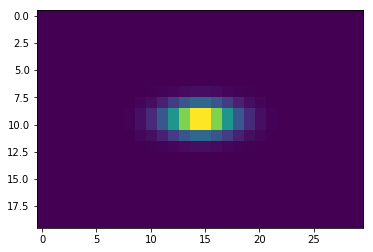

2d integrated intensity (x):


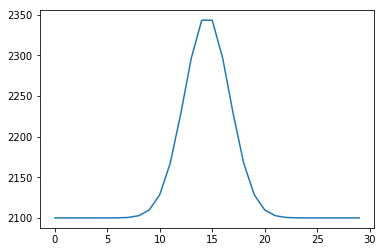

2d integrated intensity (y):


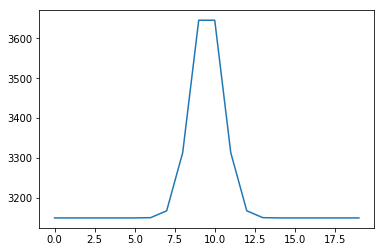

2d integrated intensity (z):


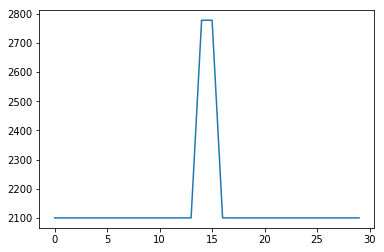

total integrated intensity: 1354.50990548


In [452]:
print("original profile (no noise):")
plt.imshow(original_image[:,:,15])
plt.show()

print("2d integrated intensity (x):")
integrated2d_x = [ original_image[:,x,:].sum() for x in range(width)]
plt.plot(integrated2d_x)
plt.show()

print("2d integrated intensity (y):")
integrated2d_y = [ original_image[y,:,:].sum() for y in range(height)]
plt.plot(integrated2d_y)
plt.show()

print("2d integrated intensity (z):")
integrated2d_z = [ original_image[:,:,z].sum() for z in range(duration)]
plt.plot(integrated2d_z)
plt.show()

print("total integrated intensity:", original_intensity)

noisy image:


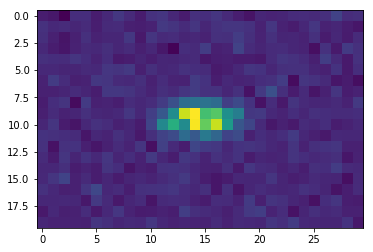

2d integrated noisy intensity (x):


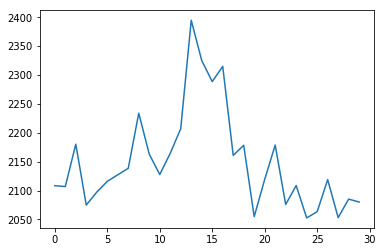

2d integrated noisy intensity (y):


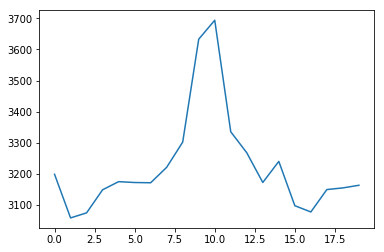

2d integrated noisy intensity (z):


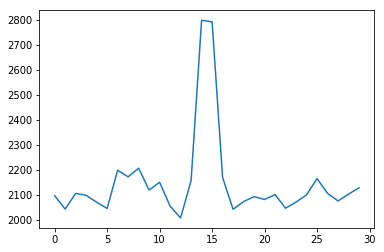

In [453]:
s = np.random.normal(0.0, 1.0, width*height*duration)
noise = np.reshape(s, [height, width, duration])*np.sqrt(original_image*poisson_scale)
noisy_image = original_image + noise

print("noisy image:")
plt.imshow(noisy_image[:,:,15])
plt.show()

print("2d integrated noisy intensity (x):")
integrated2d_x = [ noisy_image[:,x,:].sum() for x in range(width)]
plt.plot(integrated2d_x)
plt.show()

print("2d integrated noisy intensity (y):")
integrated2d_y = [ noisy_image[y,:,:].sum() for y in range(height)]
plt.plot(integrated2d_y)
plt.show()

print("2d integrated noisy intensity (z):")
integrated2d_z = [ noisy_image[:,:,z].sum() for z in range(duration)]
plt.plot(integrated2d_z)
plt.show()


peak mask:


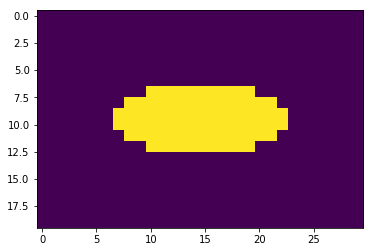

background mask:


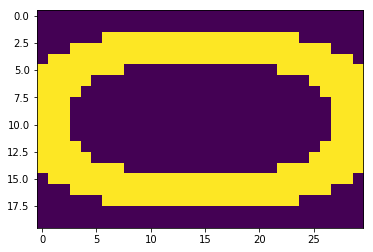

In [469]:
r1 = 4
r2 = 6
r3 = 9

peak_mask = arg < r1*r1
background_mask = (arg > r2*r2) * (arg < r3*r3)
print('peak mask:')
plt.imshow(peak_mask[:,:,15])
plt.show()

print('background mask:')
plt.imshow(background_mask[:,:,15])
plt.show()

In [471]:
npeak = peak_mask.sum()
nbkg = background_mask.sum()

obs_background = (background_mask*noisy_image).sum() / nbkg
peak_intensity = (peak_mask*noisy_image).sum() - npeak*obs_background
exact_sigma = poisson_scale*np.sqrt( (peak_mask*noisy_image).sum() + npeak*obs_background)

std2_bkg = ((background_mask*(noisy_image-obs_background))**2).sum() / (nbkg-1)
obs_scale = std2_bkg / obs_background

var1 = obs_scale*obs_scale*(peak_mask*noisy_image).sum()
var2 = npeak*std2_bkg

calc_sigma = np.sqrt(var1 + var2 + 2*np.sqrt(var1*var2))

print("exact background:", mean_background)
print("calculated background:", obs_background)
print("calculted scale:", obs_scale)

print("exact intensity:", original_intensity)
print("calculated intensity:", peak_intensity)

print("error in intensity:", (peak_intensity-original_intensity)/original_intensity*100, "%")

print("exact sigma:", exact_sigma)
print("calculated sigma:", calc_sigma)
print("delta I / sigma:", (peak_intensity-original_intensity)/exact_sigma)


exact background: 3.5
calculated background: 3.52479453129
calculted scale: 1.0641384524
exact intensity: 1354.50990548
calculated intensity: 1367.62248132
error in intensity: 0.968067917885 %
exact sigma: 49.9555475531
calculated sigma: 71.2664655928
delta I / sigma: 0.262484878693


In [456]:
print(npeak*std2_bkg)
print(obs_scale*obs_background*npeak)

559.799165827
559.799165827


In [457]:

print(np.sqrt(var1+var2))
print(np.sqrt(var1+var2+2*np.sqrt(var1*var2)))

49.8357693719
67.5212739604
